# Thermocap Multiple

### How to calculate
- Take the bitcoin price on a given day and divide by the total historical block subsidy.
- This total historical block subsidy is calculated by taking the amount of bitcoins minted on each day and multiplying them by the end of day price on that day.
- Then you add all of these daily subsidies up for every day previous to the one you are looking at. 

### Formula

$\text{Thermocap Multiple} = \frac {\text{BTC}(t,\$)}{\displaystyle \sum_{t=0}^n \Big[ \text{BTC}(t,\$) \cdot \text{BlockReward}(t) \Big]}$

### Sources

[1] https://charts.bitbo.io/thermocap-multiple/ 

[2] https://www.tradingview.com/script/WdnPvtn7-Bitcoin-Thermocap-InvestorUnknown/

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

### Get data from sources

In [2]:
chrome_options = Options()
chrome_options.add_argument("--headless")

driver = webdriver.Chrome(options=chrome_options)

driver.get("https://studio.glassnode.com/metrics?a=BTC&m=blockchain.BlockCount")

# Block count
driver.get("https://api.glassnode.com/v1/metrics/blockchain/block_count?a=BTC&c=native&i=24h&referrer=charts")
block_element = driver.find_element(By.TAG_NAME, "pre")
block = block_element.text

# BTC
driver.get("https://api.glassnode.com/v1/metrics/market/price_usd_close?a=BTC&i=24h&referrer=charts")
btc_element = driver.find_element(By.TAG_NAME, "pre")
btc = btc_element.text

driver.quit()

In [3]:
block_json = json.loads(block)
btc_json = json.loads(btc)

block = pd.DataFrame(block_json)
block['t'] = pd.to_datetime(block['t'], unit='s')

btc = pd.DataFrame(btc_json)
btc['t'] = pd.to_datetime(btc['t'], unit='s')

df = btc.merge(block, how='right', on='t', suffixes=('_btc', '_block'))
df = df.rename(columns={'t': 'Date', 'v_btc': 'BTC_Price', 'v_block': 'Blocks_Mined'})
df

,Date,BTC_Price,Blocks_Mined
0,2009-01-03,NaN,1
1,2009-01-04,NaN,0
2,2009-01-05,NaN,0
3,2009-01-06,NaN,0
4,2009-01-07,NaN,0
...,...,...,...
5693,2024-08-05,54017.787525,156
5694,2024-08-06,56002.987864,140
5695,2024-08-07,55041.603924,122
5696,2024-08-08,61784.680767,129


### Visualize the data

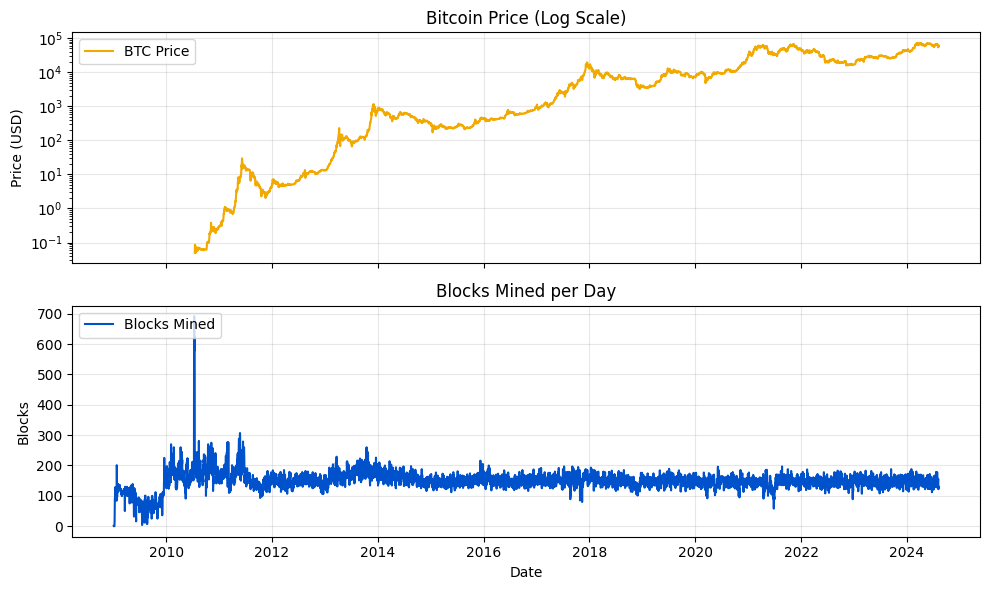

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# BTC Price plot
ax1.plot(df['Date'], df['BTC_Price'], label='BTC Price', color='#f2a900')
ax1.set_yscale("log")
ax1.set_ylabel('Price (USD)')
ax1.set_title('Bitcoin Price (Log Scale)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Blocks Mined plot
ax2.plot(df['Date'], df['Blocks_Mined'], label='Blocks Mined', color='#0052cc')
ax2.set_ylabel('Blocks')
ax2.set_xlabel('Date')
ax2.set_title('Blocks Mined per Day')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Create the normalized Oscillator

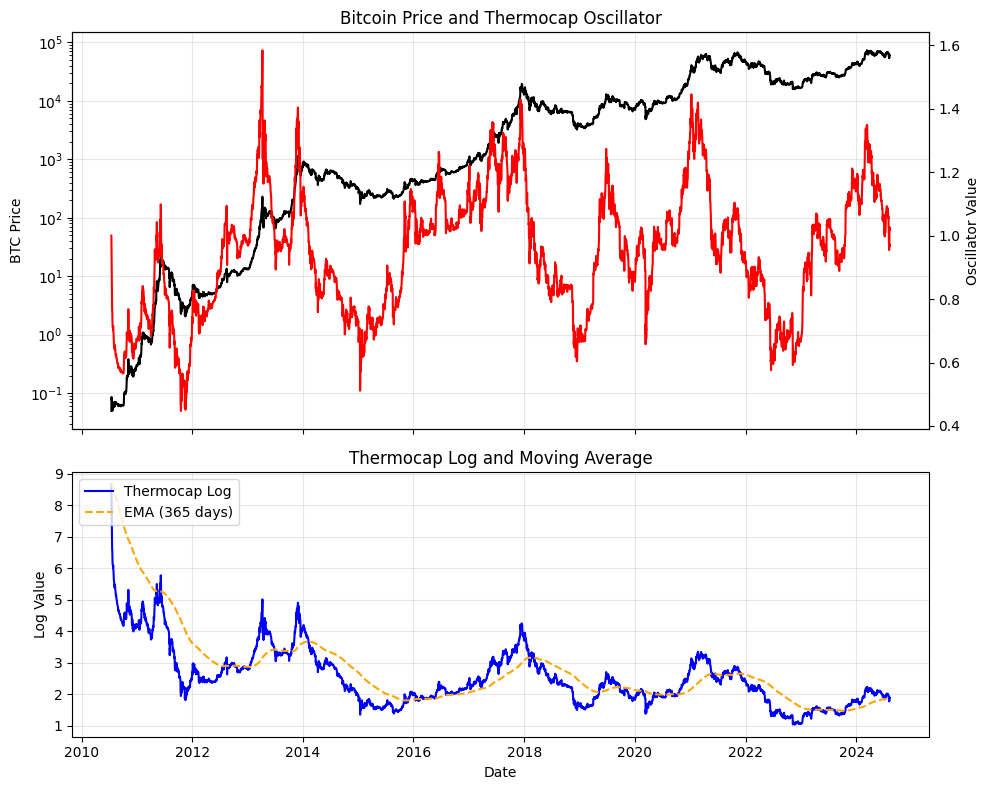

In [5]:
########### Calculations
ma_len = 365
ma_type = 'EMA'

# Calculate thermocap
df['Historical_Blocks'] = (df['Blocks_Mined'] * df['BTC_Price']).cumsum()
df['Thermocap'] = (df['BTC_Price'] / df['Historical_Blocks']) * 1000000

# Normalize thermocap
df['Thermocap_Log'] = np.log(df['Thermocap'])

if ma_type == 'SMA':
    df['MA'] = df['Thermocap_Log'].rolling(window=ma_len).mean()
elif ma_type == 'EMA':
    df['MA'] = df['Thermocap_Log'].ewm(span=ma_len, adjust=False).mean()

df['MA_Oscillator'] = df['Thermocap_Log'] / df['MA']

df = df.dropna()


########### PLot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

# Bitcoin price and Thermocap Oscillator plot
ax1.plot(df['Date'], df['BTC_Price'], label='Bitcoin Price', color='black')
ax1.set_ylabel('BTC Price')
ax1.set_yscale('log')
ax1.set_title('Bitcoin Price and Thermocap Oscillator')
ax1.grid(True, alpha=0.3)

ax1_twin = ax1.twinx()
ax1_twin.plot(df['Date'], df['MA_Oscillator'], color='red')
ax1_twin.set_ylabel('Oscillator Value')

# Thermocap Log and MA plot
ax2.plot(df['Date'], df['Thermocap_Log'], label='Thermocap Log', color='blue')
ax2.plot(df['Date'], df['MA'], label=f'{ma_type} ({ma_len} days)', color='orange', linestyle='--')
ax2.set_ylabel('Log Value')
ax2.set_xlabel('Date')
ax2.set_title('Thermocap Log and Moving Average')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()